# Pair Trading
### Contents
1. (Prepare) pip install & library
2. (Input) Ticker & Exchange
3. (Load) Load a price data via FinanceDataReader
4. (Pre-process) Unify a unit of currency
5. (Pre-process) Remove redundant "nan" rows
6. (Calculate) Calculate spreads and error rates of spread
7. Result
8. Reference

### 1. (Prepare) pip install & library

In [1]:
!pip install -U finance-datareader

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import FinanceDataReader as fdr
print(np.__version__)
print(pd.__version__)
print(plt.__version__)
print(fdr.__version__)

1.21.5
1.4.4
1.21.5
0.9.50


### 2. (Input) Ticker & Exchange

In [59]:
#ticker1, ticker2 = input("tickers separated by whitespace (e.g. ""005930 000660"") ").split()

ticker1 = '000660' #
ticker2 = 'MU' #
exchange1 = 'KRX'
exchange2 = 'NASDAQ'
date_start = '2012-12-18'
date_end = '2022-12-18'

tag1 = exchange1 + ':' + ticker1
tag2 = exchange2 + ':' + ticker2

print("TAG1: ", tag1)
print("TAG2: ", tag2)

TAG1:  KRX:000660
TAG2:  NASDAQ:MU


### 3. (Load) Load a price data via FinanceDataReader

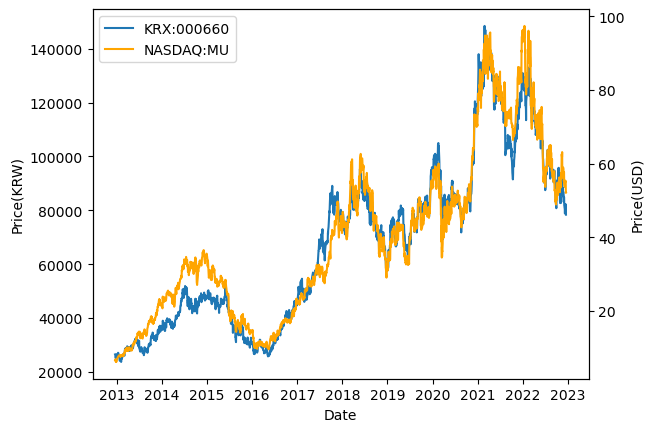

In [60]:
df1 = fdr.DataReader(symbol=ticker1, start=date_start, end=date_end, exchange=exchange1)
df2 = fdr.DataReader(symbol=ticker2, start=date_start, end=date_end, exchange=exchange2)

exchange = {'NYSE':'USD', 'NASDAQ':'USD', 'AMEX':'USD', 'OTC':'USD', 'EURONEXT':'EUR', 'XETR':'EUR', 'KRX':'KRW', 'TSE':'JPY', 'SZSE':'CNY', 'SSE':'CNY', 'HKEX':'HKD'}
currency = ['USD/KRW', 'USD/EUR', 'USD/JPY', 'CNY/KRW', 'EUR/USD', 'USD/JPY', 'JPY/KRW', 'AUD/USD', 'EUR/JPY', 'USD/RUB', 'USD/HKD', 'EUR/HKD']
unit1 = exchange[exchange1]
unit2 = exchange[exchange2]

# For plot
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date')
ax1.set_ylabel('Price(' + unit1 + ')')
line1 = ax1.plot(df1['Close'], label=tag1)

ax2 = ax1.twinx()
ax2.set_xlabel('Date')
ax2.set_ylabel('Price(' + unit2 + ')')
line2 = ax2.plot(df2['Close'], color='orange', label=tag2)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best')
#df1['Close'].plot(xlabel='Date', ylabel='Price', grid=True)
#df2['Close'].plot(xlabel='Date', ylabel='Price', grid=True)

### 4. (Pre-process) Unify a unit of currency

<AxesSubplot:xlabel='Date', ylabel='Price(USD)'>

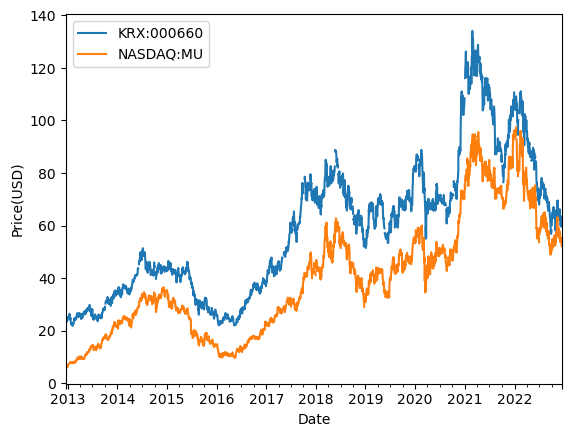

In [61]:
y_label = unit1
if unit1 != unit2:
    if unit1 + '/' + unit2 in currency:
        df_currency = fdr.DataReader(unit1 + '/' + unit2, start=date_start, end=date_end)
        df_temp = pd.concat([df2['Close'], df_currency['Close']], axis=1, keys=['df2', 'currency'])
        df_temp = df_temp['df2'].div(df_temp['currency'])
        df = pd.concat([df1['Close'], df_temp], axis=1, keys=[tag1, tag2])
    elif unit2 + '/' + unit1 in currency:
        df_currency = fdr.DataReader(unit2 + '/' + unit1, start=date_start, end=date_end)
        df_temp = pd.concat([df1['Close'], df_currency['Close']], axis=1, keys=['df1', 'currency'])
        df_temp = df_temp['df1'].div(df_temp['currency'])
        df = pd.concat([df_temp, df2['Close']], axis=1, keys=[tag1, tag2])
        y_label = unit2
        # Temp for Samsung SDI vs BYD. Co (Errors in loading CNY/KRW data)
        #df_USDCNY = fdr.DataReader('USD/CNY', start=date_start, end=date_end)
        #df_USDKRW = fdr.DataReader('USD/KRW', start=date_start, end=date_end)
        #df_temp1 = pd.concat([df1['Close'], df_USDKRW['Close']], axis=1, keys=['df1', 'currency'])
        #df_temp2 = pd.concat([df2['Close'], df_USDCNY['Close']], axis=1, keys=['df2', 'currency'])
        #df_temp1 = df_temp1['df1'].div(df_temp1['currency'])
        #df_temp2 = df_temp2['df2'].div(df_temp2['currency'])
        #df = pd.concat([df_temp1, df_temp2], axis=1, keys=[tag1, tag2])
        #y_label = 'USD'
else:
    df = pd.concat([df1['Close'], df2['Close']], axis=1, keys=[tag1, tag2])

# For plot
#fig, ax1 = plt.subplots()
#ax1.set_xlabel('Date')
#ax1.set_ylabel('Price(' + y_label + ')')
#line1 = ax1.plot(df[tag1], label=tag1+'(L)')

#ax2 = ax1.twinx()
#ax2.set_xlabel('Date')
#ax2.set_ylabel('Price(' + y_label + ')')

#line2 = ax2.plot(df[tag2], color='orange', label=tag2+'(R)')
#lines = line1 + line2
#labels = [l.get_label() for l in lines]
#ax1.legend(lines, labels, loc='best')
df.plot(xlabel='Date', ylabel='Price(' + y_label + ')')

### 5. (Pre-process) Remove redundant "nan" rows

In [62]:
df = df.dropna(axis=0)

### 6. (Calculate) Calculate spreads and error rates of spread

In [63]:
ln_df1 = np.log(df[tag1])
ln_df2 = np.log(df[tag2])

In [64]:
COEF_correlation = np.corrcoef(ln_df1, ln_df2)[0, 1]
COEF_cointegration = np.cov(ln_df1, ln_df2)[0, 1] / np.var(ln_df2)

In [65]:
spread = ln_df1.add(ln_df2.mul(-1 * COEF_cointegration))

AVG_spread = np.average(spread)

In [66]:
err = spread.add(-1 * AVG_spread)
STD_err = np.std(err)

### 7. Result

COEF_correlation:  0.970381
COEF_cointegration:  0.714987
STD_err:  0.113124


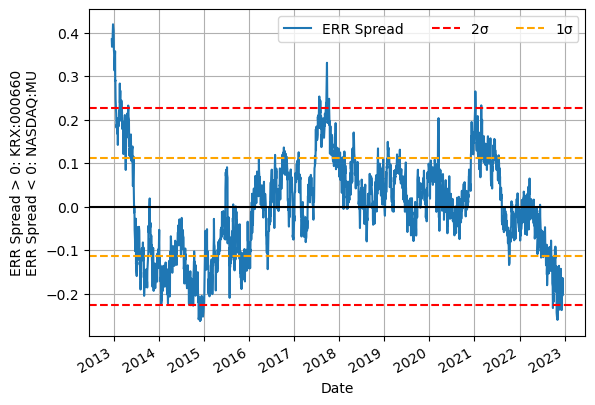

In [67]:
print("COEF_correlation: ", round(COEF_correlation, 6))
print("COEF_cointegration: ", round(COEF_cointegration, 6))
print("STD_err: ", round(STD_err, 6))

# For plot
err.plot(xlabel='Date', ylabel='ERR Spread > 0: ' + tag1 + '\n' + 'ERR Spread < 0: ' + tag2, grid=True, label='ERR Spread')

plt.axhline(0, color='black')
plt.axhline(2 * STD_err, color='red', linestyle='--', label='2σ')
plt.axhline(1 * STD_err, color='orange', linestyle='--', label='1σ')
plt.axhline(-1 * STD_err, color='orange', linestyle='--')
plt.axhline(-2 * STD_err, color='red', linestyle='--')
plt.legend(loc='best', ncol=3)

### 8. Reference
* [Pair Trading, wikipedia](https://en.wikipedia.org/wiki/Pairs_trade)
* [페어 트레이딩을 이용한 롱숏 전략, IBK Securities](https://www.ibks.com/index.do)
* [페어 트레이딩/기초편 8. 로그 스프레드](https://insightcampus.co.kr/2019/01/07/%ED%8E%98%EC%96%B4-%ED%8A%B8%EB%A0%88%EC%9D%B4%EB%94%A9-%EA%B8%B0%EC%B4%88%ED%8E%B8-8-%EB%A1%9C%EA%B7%B8-%EC%8A%A4%ED%94%84%EB%A0%88%EB%93%9C/)
* [FinanceDataReader](https://financedata.github.io/posts/finance-data-reader-users-guide.html)
* [Matplotlib, plot](https://codetorial.net/matplotlib/set_legend.html)